In [7]:
import pandas as pd
import numpy as np
import requests
import statsmodels.api as sm
from pandas.tseries.offsets import BDay

# --- Function to Convert Annual Yield to Daily Yield ---
def annual_to_daily_yield(annual_yield):
    """
    Convert annual yield to daily yield assuming 260 trading days in a year.
    
    Parameters:
    annual_yield (float): The annual yield in percentage (e.g., 1.71 for 1.71%)
    
    Returns:
    float: The daily compounded yield in percentage
    """
    daily_yield = ((1 + annual_yield / 100) ** (1 / 260) - 1) * 100
    return daily_yield

# --- STEP 1: Load and Process Stock Data ---

# Load the CSV file, replacing commas with dots and ensuring all data is treated as floats
prices = pd.read_csv('Returns_with_t0.csv', sep=';', dtype=str)

# Replace NaNs with zeros
prices = prices.fillna(0)

for i in range(1, len(prices), 2):
    prices.at[i, 'Code'] = 'Rm'

# Convert the 'T-1Y' and 'T+1Y' columns to datetime format
prices['T-1Y'] = pd.to_datetime(prices['T-1Y'], format='%d/%m/%Y', errors='coerce')
prices['T+1Y'] = pd.to_datetime(prices['T+1Y'], format='%d/%m/%Y', errors='coerce')

# Subtract 5 days from the dates in the 'T-1Y' and 'T+1Y' columns
prices['T-1Y'] = prices['T-1Y'] - pd.Timedelta(days=5)
prices['T+1Y'] = prices['T+1Y'] - pd.Timedelta(days=5)

print(prices.head())


# --- STEP 1A: Remove Stocks with More Than 20% Zero Trading Days ---

import numpy as np

# Replace commas with dots and convert to float where possible for trading data columns
prices = prices.replace({',': '.'}, regex=True)

# Assuming that trading data starts from column index 7 onward
trading_columns = prices.columns[7:]

# Convert trading data columns to numeric
prices[trading_columns] = prices[trading_columns].apply(pd.to_numeric, errors='coerce')

# Initialize a list to keep track of indices to drop
indices_to_drop = []

# Loop through each firm's data (assuming firm data is every other row, and 'Rm' is the row below it)
for i in range(0, len(prices), 2):  # Step by 2 to process only stock rows
    firm_code = prices.at[i, 'Code']
    firm_data = prices.iloc[i][trading_columns]
    total_days = len(firm_data)
    zero_days = (firm_data == 0).sum()
    zero_percentage = zero_days / total_days

    if zero_percentage > 0.2:
        # Mark both the firm row and the corresponding 'Rm' row for deletion
        indices_to_drop.extend([i, i+1])
        print(f"Removing {firm_code}: {zero_percentage:.2%} zero trading days.")

# Drop the rows with indices in indices_to_drop
prices = prices.drop(indices_to_drop).reset_index(drop=True)

print("\nDataFrame after removing stocks with more than 20% zero trading days:")
print(prices.head())



# --- STEP 2: Fetch U.S. Treasury Yield Data from Alpha Vantage ---
# Alpha Vantage API key
# api_key = '56TS94GBJS6B8P7X'
# api_key = 'VMKWLBGLKM7BBJTQ'

# # VMKWLBGLKM7BBJTQ

# # URL to request U.S. Treasury Yield data (example for the 10-year yield)
# url = f'https://www.alphavantage.co/query?function=TREASURY_YIELD&interval=daily&maturity=10year&apikey={api_key}'

# # Request the data
# response = requests.get(url)
# data = response.json()

# print(data)

# # Check if 'data' exists in the response
# if 'data' not in data:
#     raise ValueError("No yield data found in API response")

# # Extract the 'data' part which contains daily yields
# yield_data = data['data']

# # Convert the data into a pandas DataFrame
# df_yield = pd.DataFrame(yield_data)

# # Check if 'date' and 'value' columns exist
# if 'date' not in df_yield.columns or 'value' not in df_yield.columns:
#     raise ValueError("The expected 'date' or 'value' columns are missing in the yield data")

# # Convert the 'date' column to datetime
# df_yield['date'] = pd.to_datetime(df_yield['date'], errors='coerce')

# # Drop rows where 'date' conversion failed
# df_yield = df_yield.dropna(subset=['date'])

# # Set the 'date' column as the index for easier filtering
# df_yield.set_index('date', inplace=True)

# # Convert the 'value' column to numeric type, coercing errors to NaN
# df_yield['value'] = pd.to_numeric(df_yield['value'], errors='coerce')

# # Drop rows where 'value' is NaN (holes in the data)
# df_yield = df_yield.dropna(subset=['value'])

# # Convert annual yield to daily yield
# df_yield['daily_value'] = df_yield['value'].apply(annual_to_daily_yield)

# --- STEP 3: Process Stock Data for Abnormal Returns Calculation ---
# Ensure 'prices' DataFrame is processed correctly

# Drop irrelevant columns
prices = prices.drop('SPLIT', axis=1)

# Replace commas with dots and convert to float where possible
prices = prices.replace({',': '.'}, regex=True).apply(pd.to_numeric, errors='ignore')

# Convert 'Date' to datetime format, handling errors
prices['date'] = pd.to_datetime(prices['Date'], format='%d/%m/%Y', errors='coerce')

# Create a DataFrame to store the abnormal returns
abnormal_returns = pd.DataFrame()

# Save the cleaned yield data to CSV
# df_yield.to_csv('risk_free_rates.csv', sep=';')

# print(df_yield.head())




/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/4163741820.py:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  prices = prices.fillna(0)


   Code                        Name          ISIN        Date Factor  \
0  ECGR           Kinetic Seas Inc.  US07831X2062  06/05/2023    100   
1    Rm                           0             0           0      0   
2  SKIL      Skillsoft Corp Class A  US83066P3091  10/02/2023     20   
3    Rm                           0             0           0      0   
4  VISL  Vislink Technologies, Inc.  US92836Y4098  05/01/2023     20   

        T-1Y       T+1Y       T-255       T-254        T-253  ...       T+245  \
0 2022-05-01 2024-04-30           0  -41,843975   -23,170734  ...   26,190472   
1        NaT        NaT  -0,5674243   -3,203708   0,24578571  ...   1,0209084   
2 2022-02-05 2024-02-05  -2,6825547  -2,2970915   -1,7241418  ...  -11,111111   
3        NaT        NaT  -1,8115699  -1,8969476  -0,38406253  ...    1,068449   
4 2021-12-31 2023-12-31  -6,5040646  -3,4782588   0,90090036  ...   1,7344475   

        T+246       T+247       T+248        T+249       T+250 T+251 T+252  \
0 

/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/4163741820.py:135: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  prices = prices.replace({',': '.'}, regex=True).apply(pd.to_numeric, errors='ignore')


In [8]:
df_yield = pd.read_csv('risk_free_rates.csv', sep=';', parse_dates=['date'])
df_yield.set_index('date', inplace=True)
date = pd.to_datetime('1962-01-08')
print(df_yield.loc[date]['daily_value'])

0.0151969750443292


In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pandas.tseries.offsets import BDay

def get_nearest_risk_free_rate(adjusted_date, df_yield):
    risk_free_rate = get_risk_free_rate(adjusted_date, df_yield)
    
    if risk_free_rate is None:
        # If the risk-free rate is missing, attempt to use the nearest available
        # Forward fill and backward fill in the risk-free rate DataFrame
        df_yield_filled = df_yield['daily_value'].ffill().bfill()  # Fill missing values
        
        # Try getting the filled value
        risk_free_rate = df_yield_filled.loc[adjusted_date] if adjusted_date in df_yield_filled.index else None
    
    return risk_free_rate


# Function to calculate the new date based on "T+i" or "T-i"
def calculate_date(base_date, t_string):
    if 'T+' in t_string:
        days_to_add = int(t_string.split('+')[1])
        new_date = base_date + BDay(days_to_add)  # Add business days
    elif 'T-' in t_string:
        days_to_subtract = int(t_string.split('-')[1])
        new_date = base_date - BDay(days_to_subtract)  # Subtract business days
    return new_date.date()  # Return only the date part


# Function to get the daily risk-free rate for a given date
def get_risk_free_rate(query_date, df_yield):
    try:
        return df_yield.loc[query_date]['daily_value']
    except KeyError:
        return None  # Handle cases where the date is not found

# Empty DataFrame to store abnormal returns for each firm
abnormal_returns = pd.DataFrame()

# Loop through each firm's data (assuming firm data is every other row, and 'Rm' is the row below it)
for i in range(0, len(prices), 2):  # Step by 2 to skip 'Rm' rows
    firm_name = prices.iloc[i, 0]  # Assuming firm ticker is in the first column

    # print(firm_name)

    # Select only numeric columns for returns (columns after the 6th one and excluding 'date')
    firm_returns = prices.iloc[i:i+1, 7:].select_dtypes(include=[np.number]).iloc[0]
    market_returns = prices.iloc[i+1:i+2, 7:].select_dtypes(include=[np.number]).iloc[0]
    
    # Create a list to store risk-free rates for each day
    risk_free_rates = []

    # For each "T+i" or "T-i" column, get the adjusted date and risk-free rate
    for col in prices.columns[7:]:
        L = len(prices.columns[7:])
        if 'T+' in col or 'T-' in col:
            adjusted_date = calculate_date(prices.loc[i, 'date'], col)
            adjusted_date = pd.to_datetime(adjusted_date)
            print(adjusted_date)
            risk_free_rate = get_nearest_risk_free_rate(adjusted_date, df_yield)
            # print(risk_free_rate)
            risk_free_rates.append(risk_free_rate)


    # Ensure that the length of risk-free rates matches the length of firm and market returns
    if len(risk_free_rates) != len(firm_returns):
        print(f"Warning: Risk-free rate length mismatch for {firm_name}")
        # risk_free_rates = risk_free_rates[:len(firm_returns)]  # Truncate to match length of returns
        break

    risk_free_rates = pd.Series(risk_free_rates, index=firm_returns.index)

    firm_returns_yesterday = firm_returns.shift(1)
    market_returns_yesterday = market_returns.shift(1)
    firm_excess_returns = 100 * (firm_returns / firm_returns_yesterday) - risk_free_rates
    market_excess_returns = 100 * (market_returns / market_returns_yesterday) - risk_free_rates
    
    # Convert firm and market returns to excess returns (return - daily risk-free rate for each date)
    # firm_excess_returns = firm_returns - risk_free_rates
    # market_excess_returns = market_returns - risk_free_rates
    
    # Combine firm and market returns into a DataFrame to remove NaNs and inf values
    combined_data = pd.DataFrame({
        'firm_excess_returns': firm_excess_returns,
        'market_excess_returns': market_excess_returns
    })

    #  # Check for NaN values in combined data
    # if combined_data.isna().sum().sum() > 0:
    #     print(f"Warning: NaN values found for {firm_name} in combined data.")
    #     print(combined_data.isna().sum())  # Print number of NaNs in each column

    # # Check for zero values in combined data
    # if (combined_data == 0).sum().sum() > 0:
    #     print(f"Warning: Zero values found for {firm_name} in combined data.")
    #     print((combined_data == 0).sum())  # Print number of zeros in each column
    

    # Drop rows with NaN or infinite values
    combined_data = combined_data.replace([np.inf, -np.inf], np.nan).dropna()

    # Check if there is enough data after cleaning
    if len(combined_data) < 2:
        print(f"Not enough data for firm {firm_name}, skipping...")
        continue
    
    # Perform regression (market excess return as independent variable, firm excess return as dependent variable)
    X = sm.add_constant(combined_data['market_excess_returns'])  # Add intercept (alpha)
    Y = combined_data['firm_excess_returns']
    model = sm.OLS(Y, X).fit()
    
    # Extract alpha and beta from the regression
    alpha = model.params['const']
    beta = model.params['market_excess_returns']  # Beta corresponds to market return slope
    
    # Calculate abnormal returns: R_it = alpha + beta * R_m
    abnormal_return = alpha + (beta * combined_data['market_excess_returns'])  # Expected firm return
    
    # Add the abnormal returns to the DataFrame
    abnormal_returns[firm_name] = round(abnormal_return, 4)

# Save the abnormal returns DataFrame to a CSV file
abnormal_returns.to_csv('abnormal_returns_compounded.csv', sep=';')

# Optional: display a preview of the abnormal returns
print(abnormal_returns.head())


2022-02-18 00:00:00
2022-02-21 00:00:00
2022-02-22 00:00:00
2022-02-23 00:00:00
2022-02-24 00:00:00
2022-02-25 00:00:00
2022-02-28 00:00:00
2022-03-01 00:00:00
2022-03-02 00:00:00
2022-03-03 00:00:00
2022-03-04 00:00:00
2022-03-07 00:00:00
2022-03-08 00:00:00
2022-03-09 00:00:00
2022-03-10 00:00:00
2022-03-11 00:00:00
2022-03-14 00:00:00
2022-03-15 00:00:00
2022-03-16 00:00:00
2022-03-17 00:00:00
2022-03-18 00:00:00
2022-03-21 00:00:00
2022-03-22 00:00:00
2022-03-23 00:00:00
2022-03-24 00:00:00
2022-03-25 00:00:00
2022-03-28 00:00:00
2022-03-29 00:00:00
2022-03-30 00:00:00
2022-03-31 00:00:00
2022-04-01 00:00:00
2022-04-04 00:00:00
2022-04-05 00:00:00
2022-04-06 00:00:00
2022-04-07 00:00:00
2022-04-08 00:00:00
2022-04-11 00:00:00
2022-04-12 00:00:00
2022-04-13 00:00:00
2022-04-14 00:00:00
2022-04-15 00:00:00
2022-04-18 00:00:00
2022-04-19 00:00:00
2022-04-20 00:00:00
2022-04-21 00:00:00
2022-04-22 00:00:00
2022-04-25 00:00:00
2022-04-26 00:00:00
2022-04-27 00:00:00
2022-04-28 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

2012-10-31 00:00:00
2012-11-01 00:00:00
2012-11-02 00:00:00
2012-11-05 00:00:00
2012-11-06 00:00:00
2012-11-07 00:00:00
2012-11-08 00:00:00
2012-11-09 00:00:00
2012-11-12 00:00:00
2012-11-13 00:00:00
2012-11-14 00:00:00
2012-11-15 00:00:00
2012-11-16 00:00:00
2012-11-19 00:00:00
2012-11-20 00:00:00
2012-11-21 00:00:00
2012-11-22 00:00:00
2012-11-23 00:00:00
2012-11-26 00:00:00
2012-11-27 00:00:00
2012-11-28 00:00:00
2012-11-29 00:00:00
2012-11-30 00:00:00
2012-12-03 00:00:00
2012-12-04 00:00:00
2012-12-05 00:00:00
2012-12-06 00:00:00
2012-12-07 00:00:00
2012-12-10 00:00:00
2012-12-11 00:00:00
2012-12-12 00:00:00
2012-12-13 00:00:00
2012-12-14 00:00:00
2012-12-17 00:00:00
2012-12-18 00:00:00
2012-12-19 00:00:00
2012-12-20 00:00:00
2012-12-21 00:00:00
2012-12-24 00:00:00
2012-12-25 00:00:00
2012-12-26 00:00:00
2012-12-27 00:00:00
2012-12-28 00:00:00
2012-12-31 00:00:00
2013-01-01 00:00:00
2013-01-02 00:00:00
2013-01-03 00:00:00
2013-01-04 00:00:00
2013-01-07 00:00:00
2013-01-08 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

2012-11-13 00:00:00
2012-11-14 00:00:00
2012-11-15 00:00:00
2012-11-16 00:00:00
2012-11-19 00:00:00
2012-11-20 00:00:00
2012-11-21 00:00:00
2012-11-22 00:00:00
2012-11-23 00:00:00
2012-11-26 00:00:00
2012-11-27 00:00:00
2012-11-28 00:00:00
2012-11-29 00:00:00
2012-11-30 00:00:00
2012-12-03 00:00:00
2012-12-04 00:00:00
2012-12-05 00:00:00
2012-12-06 00:00:00
2012-12-07 00:00:00
2012-12-10 00:00:00
2012-12-11 00:00:00
2012-12-12 00:00:00
2012-12-13 00:00:00
2012-12-14 00:00:00
2012-12-17 00:00:00
2012-12-18 00:00:00
2012-12-19 00:00:00
2012-12-20 00:00:00
2012-12-21 00:00:00
2012-12-24 00:00:00
2012-12-25 00:00:00
2012-12-26 00:00:00
2012-12-27 00:00:00
2012-12-28 00:00:00
2012-12-31 00:00:00
2013-01-01 00:00:00
2013-01-02 00:00:00
2013-01-03 00:00:00
2013-01-04 00:00:00
2013-01-07 00:00:00
2013-01-08 00:00:00
2013-01-09 00:00:00
2013-01-10 00:00:00
2013-01-11 00:00:00
2013-01-14 00:00:00
2013-01-15 00:00:00
2013-01-16 00:00:00
2013-01-17 00:00:00
2013-01-18 00:00:00
2013-01-21 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

2012-05-29 00:00:00
2012-05-30 00:00:00
2012-05-31 00:00:00
2012-06-01 00:00:00
2012-06-04 00:00:00
2012-06-05 00:00:00
2012-06-06 00:00:00
2012-06-07 00:00:00
2012-06-08 00:00:00
2012-06-11 00:00:00
2012-06-12 00:00:00
2012-06-13 00:00:00
2012-06-14 00:00:00
2012-06-15 00:00:00
2012-06-18 00:00:00
2012-06-19 00:00:00
2012-06-20 00:00:00
2012-06-21 00:00:00
2012-06-22 00:00:00
2012-06-25 00:00:00
2012-06-26 00:00:00
2012-06-27 00:00:00
2012-06-28 00:00:00
2012-06-29 00:00:00
2012-07-02 00:00:00
2012-07-03 00:00:00
2012-07-04 00:00:00
2012-07-05 00:00:00
2012-07-06 00:00:00
2012-07-09 00:00:00
2012-07-10 00:00:00
2012-07-11 00:00:00
2012-07-12 00:00:00
2012-07-13 00:00:00
2012-07-16 00:00:00
2012-07-17 00:00:00
2012-07-18 00:00:00
2012-07-19 00:00:00
2012-07-20 00:00:00
2012-07-23 00:00:00
2012-07-24 00:00:00
2012-07-25 00:00:00
2012-07-26 00:00:00
2012-07-27 00:00:00
2012-07-30 00:00:00
2012-07-31 00:00:00
2012-08-01 00:00:00
2012-08-02 00:00:00
2012-08-03 00:00:00
2012-08-06 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

2010-04-22 00:00:00
2010-04-23 00:00:00
2010-04-26 00:00:00
2010-04-27 00:00:00
2010-04-28 00:00:00
2010-04-29 00:00:00
2010-04-30 00:00:00
2010-05-03 00:00:00
2010-05-04 00:00:00
2010-05-05 00:00:00
2010-05-06 00:00:00
2010-05-07 00:00:00
2010-05-10 00:00:00
2010-05-11 00:00:00
2010-05-12 00:00:00
2010-05-13 00:00:00
2010-05-14 00:00:00
2010-05-17 00:00:00
2010-05-18 00:00:00
2010-05-19 00:00:00
2010-05-20 00:00:00
2010-05-21 00:00:00
2010-05-24 00:00:00
2010-05-25 00:00:00
2010-05-26 00:00:00
2010-05-27 00:00:00
2010-05-28 00:00:00
2010-05-31 00:00:00
2010-06-01 00:00:00
2010-06-02 00:00:00
2010-06-03 00:00:00
2010-06-04 00:00:00
2010-06-07 00:00:00
2010-06-08 00:00:00
2010-06-09 00:00:00
2010-06-10 00:00:00
2010-06-11 00:00:00
2010-06-14 00:00:00
2010-06-15 00:00:00
2010-06-16 00:00:00
2010-06-17 00:00:00
2010-06-18 00:00:00
2010-06-21 00:00:00
2010-06-22 00:00:00
2010-06-23 00:00:00
2010-06-24 00:00:00
2010-06-25 00:00:00
2010-06-28 00:00:00
2010-06-29 00:00:00
2010-06-30 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

2011-07-05 00:00:00
2011-07-06 00:00:00
2011-07-07 00:00:00
2011-07-08 00:00:00
2011-07-11 00:00:00
2011-07-12 00:00:00
2011-07-13 00:00:00
2011-07-14 00:00:00
2011-07-15 00:00:00
2011-07-18 00:00:00
2011-07-19 00:00:00
2011-07-20 00:00:00
2011-07-21 00:00:00
2011-07-22 00:00:00
2011-07-25 00:00:00
2011-07-26 00:00:00
2011-07-27 00:00:00
2011-07-28 00:00:00
2011-07-29 00:00:00
2011-08-01 00:00:00
2011-08-02 00:00:00
2011-08-03 00:00:00
2011-08-04 00:00:00
2011-08-05 00:00:00
2011-08-08 00:00:00
2011-08-09 00:00:00
2011-08-10 00:00:00
2011-08-11 00:00:00
2011-08-12 00:00:00
2011-08-15 00:00:00
2011-08-16 00:00:00
2011-08-17 00:00:00
2011-08-18 00:00:00
2011-08-19 00:00:00
2011-08-22 00:00:00
2011-08-23 00:00:00
2011-08-24 00:00:00
2011-08-25 00:00:00
2011-08-26 00:00:00
2011-08-29 00:00:00
2011-08-30 00:00:00
2011-08-31 00:00:00
2011-09-01 00:00:00
2011-09-02 00:00:00
2011-09-05 00:00:00
2011-09-06 00:00:00
2011-09-07 00:00:00
2011-09-08 00:00:00
2011-09-09 00:00:00
2011-09-12 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

2009-10-13 00:00:00
2009-10-14 00:00:00
2009-10-15 00:00:00
2009-10-16 00:00:00
2009-10-19 00:00:00
2009-10-20 00:00:00
2009-10-21 00:00:00
2009-10-22 00:00:00
2009-10-23 00:00:00
2009-10-26 00:00:00
2009-10-27 00:00:00
2009-10-28 00:00:00
2009-10-29 00:00:00
2009-10-30 00:00:00
2009-11-02 00:00:00
2009-11-03 00:00:00
2009-11-04 00:00:00
2009-11-05 00:00:00
2009-11-06 00:00:00
2009-11-09 00:00:00
2009-11-10 00:00:00
2009-11-11 00:00:00
2009-11-12 00:00:00
2009-11-13 00:00:00
2009-11-16 00:00:00
2009-11-17 00:00:00
2009-11-18 00:00:00
2009-11-19 00:00:00
2009-11-20 00:00:00
2009-11-23 00:00:00
2009-11-24 00:00:00
2009-11-25 00:00:00
2009-11-26 00:00:00
2009-11-27 00:00:00
2009-11-30 00:00:00
2009-12-01 00:00:00
2009-12-02 00:00:00
2009-12-03 00:00:00
2009-12-04 00:00:00
2009-12-07 00:00:00
2009-12-08 00:00:00
2009-12-09 00:00:00
2009-12-10 00:00:00
2009-12-11 00:00:00
2009-12-14 00:00:00
2009-12-15 00:00:00
2009-12-16 00:00:00
2009-12-17 00:00:00
2009-12-18 00:00:00
2009-12-21 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

2010-06-01 00:00:00
2010-06-02 00:00:00
2010-06-03 00:00:00
2010-06-04 00:00:00
2010-06-07 00:00:00
2010-06-08 00:00:00
2010-06-09 00:00:00
2010-06-10 00:00:00
2010-06-11 00:00:00
2010-06-14 00:00:00
2010-06-15 00:00:00
2010-06-16 00:00:00
2010-06-17 00:00:00
2010-06-18 00:00:00
2010-06-21 00:00:00
2010-06-22 00:00:00
2010-06-23 00:00:00
2010-06-24 00:00:00
2010-06-25 00:00:00
2010-06-28 00:00:00
2010-06-29 00:00:00
2010-06-30 00:00:00
2010-07-01 00:00:00
2010-07-02 00:00:00
2010-07-05 00:00:00
2010-07-06 00:00:00
2010-07-07 00:00:00
2010-07-08 00:00:00
2010-07-09 00:00:00
2010-07-12 00:00:00
2010-07-13 00:00:00
2010-07-14 00:00:00
2010-07-15 00:00:00
2010-07-16 00:00:00
2010-07-19 00:00:00
2010-07-20 00:00:00
2010-07-21 00:00:00
2010-07-22 00:00:00
2010-07-23 00:00:00
2010-07-26 00:00:00
2010-07-27 00:00:00
2010-07-28 00:00:00
2010-07-29 00:00:00
2010-07-30 00:00:00
2010-08-02 00:00:00
2010-08-03 00:00:00
2010-08-04 00:00:00
2010-08-05 00:00:00
2010-08-06 00:00:00
2010-08-09 00:00:00


/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  abnormal_returns[firm_name] = round(abnormal_return, 4)
/var/folders/3k/zwv52hz93g96b2yjn3w9fywm0000gn/T/ipykernel_28428/1429249721.py:121: PerformanceWarning: DataFrame is highly fragmented.  This is usually the resul

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_abnormal_returns_with_split_and_bollinger(ticker, abnormal_returns_df, prices_df, window=20):
    """
    Plot the abnormal returns for a given ticker over time with enhanced visualization,
    and annotate and mark the stock split date at T=0. Adds Bollinger Bands to show variance.
    
    Parameters:
    ticker (str): The ticker symbol of the firm whose abnormal returns to plot.
    abnormal_returns_df (pd.DataFrame): The DataFrame containing abnormal returns.
    prices_df (pd.DataFrame): The DataFrame containing stock split dates.
    window (int): The moving average window for calculating Bollinger Bands (default: 20).
    """
    # Check if the ticker exists in the DataFrame
    if ticker not in abnormal_returns_df.columns:
        print(f"Ticker {ticker} not found in the abnormal returns data.")
        return

    # Extract the abnormal returns for the given ticker
    abnormal_data = abnormal_returns_df[ticker].dropna()

    # Ensure 'date' in prices_df is datetime and fetch the split date for the given ticker
    if 'date' in prices_df.columns:
        prices_df['date'] = pd.to_datetime(prices_df['date'], errors='coerce')

    # Extract the split date for the given ticker from the prices DataFrame
    split_date = prices_df.loc[prices_df['Code'] == ticker, 'date'].values
    if len(split_date) > 0:
        split_date = pd.to_datetime(split_date[0])
        print(f"Split date for {ticker}: {split_date}")  # Debugging: print split date
    else:
        print(f"No split date found for ticker {ticker}.")
        split_date = None

    # Instead of using the actual date as the x-axis, we will use T- values
    # Let's assume the index is already aligned, and the split happens at T=0
    t_values = range(-len(abnormal_data)//2, len(abnormal_data)//2)  # Ensure length matches abnormal_data

    # Calculate Bollinger Bands
    rolling_mean = abnormal_data.rolling(window=window).mean()
    rolling_std = abnormal_data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)  # Two standard deviations above
    lower_band = rolling_mean - (rolling_std * 2)  # Two standard deviations below

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the abnormal returns
    ax.plot(t_values, abnormal_data.values, label=f'Abnormal Returns - {ticker}', color='b', lw=2, marker='o')

    # Plot the Bollinger Bands
    ax.plot(t_values, upper_band, label='Upper Band (2 Std)', color='grey', linestyle='--', lw=1.5)
    ax.plot(t_values, lower_band, label='Lower Band (2 Std)', color='grey', linestyle='--', lw=1.5)
    ax.fill_between(t_values, lower_band, upper_band, color='lightgrey', alpha=0.4)

    # Set custom x-axis ticks every 40 points to avoid crowding, label them as T values
    ax.set_xticks(t_values[::40])
    ax.set_xticklabels([f'T{("+" if t > 0 else "")}{t}' for t in t_values[::40]])

    # Get the positional index for max and min points (use positional index, not datetime)
    max_pos = abnormal_data.values.argmax()  # Position of max
    min_pos = abnormal_data.values.argmin()  # Position of min

    # Highlight max and min abnormal returns
    max_return = abnormal_data.max()
    min_return = abnormal_data.min()

    # Annotate the max point
    ax.annotate(f'Max: {max_return:.2f}', xy=(t_values[max_pos], max_return), xytext=(t_values[max_pos], max_return + 0.5),
                arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')

    # Annotate the min point
    ax.annotate(f'Min: {min_return:.2f}', xy=(t_values[min_pos], min_return), xytext=(t_values[min_pos], min_return - 0.5),
                arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')

    # Mark the split date at T=0 or close to T=0
    if split_date:
        split_index = len(t_values) // 2  # Approximate the middle index for split at T=0
        split_return = abnormal_data.iloc[split_index]

        # Annotate the split date
        ax.annotate('Split Date', xy=(0, split_return), xytext=(0, split_return + 1),
                    arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=10, color='orange')

        # Add a marker at the exact split point
        ax.plot(0, split_return, marker='x', markersize=12, color='orange', label='Split Date Marker')

    # Add labels and title
    ax.set_xlabel('T (Days)', fontsize=12)
    ax.set_ylabel('Abnormal Return', fontsize=12)
    ax.set_title(f'Abnormal Returns Over Time for {ticker} (Split Date Marked at T=0)', fontsize=14)

    # Add grid, legend, and improve layout
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage:
# Assuming `abnormal_returns` is your DataFrame containing abnormal returns,
# and `prices` is your DataFrame containing the stock split dates for each ticker:
plot_abnormal_returns_with_split_and_bollinger("QBAK", abnormal_returns, prices)


Ticker QBAK not found in the abnormal returns data.


Split date for GOOGL: 2022-07-18 00:00:00


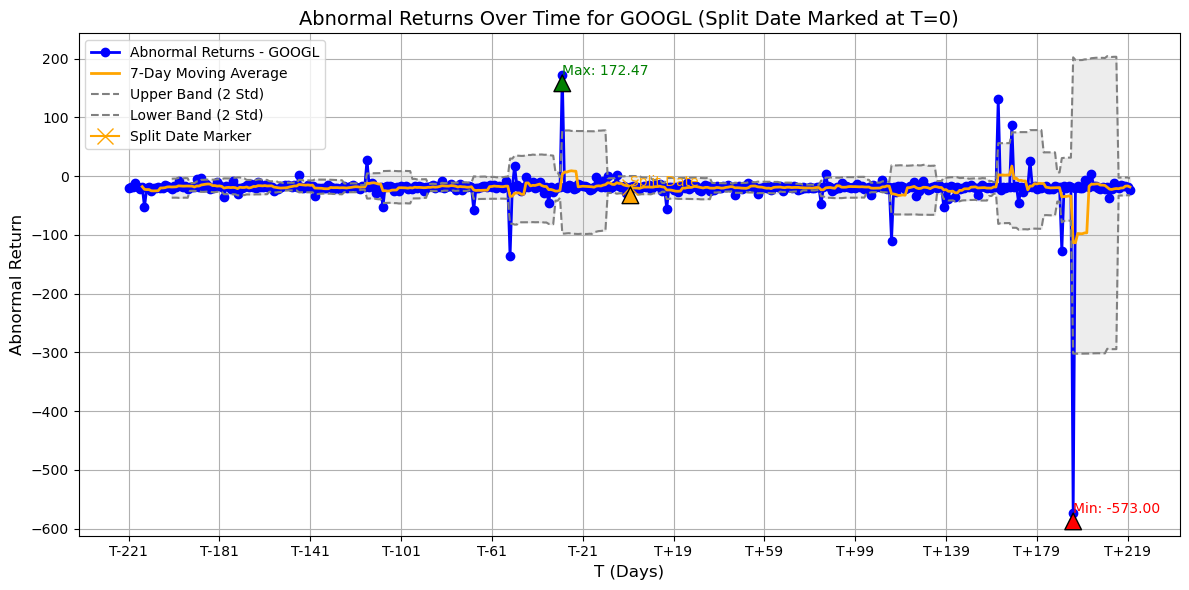

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_abnormal_returns_with_moving_average(ticker, abnormal_returns_df, prices_df, window=20, ma_window=7):
    """
    Plot the abnormal returns for a given ticker over time with enhanced visualization,
    including a 7-day rolling average. Also annotate and mark the stock split date at T=0,
    and add Bollinger Bands to show variance.
    
    Parameters:
    ticker (str): The ticker symbol of the firm whose abnormal returns to plot.
    abnormal_returns_df (pd.DataFrame): The DataFrame containing abnormal returns.
    prices_df (pd.DataFrame): The DataFrame containing stock split dates.
    window (int): The moving average window for calculating Bollinger Bands (default: 20).
    ma_window (int): The time window for calculating the rolling average (default: 7 days).
    """
    # Check if the ticker exists in the DataFrame
    if ticker not in abnormal_returns_df.columns:
        print(f"Ticker {ticker} not found in the abnormal returns data.")
        return

    # Extract the abnormal returns for the given ticker
    abnormal_data = abnormal_returns_df[ticker].dropna()

    # Ensure 'date' in prices_df is datetime and fetch the split date for the given ticker
    if 'date' in prices_df.columns:
        prices_df['date'] = pd.to_datetime(prices_df['date'], errors='coerce')

    # Extract the split date for the given ticker from the prices DataFrame
    split_date = prices_df.loc[prices_df['Code'] == ticker, 'date'].values
    if len(split_date) > 0:
        split_date = pd.to_datetime(split_date[0])
        print(f"Split date for {ticker}: {split_date}")  # Debugging: print split date
    else:
        print(f"No split date found for ticker {ticker}.")
        split_date = None

    # Instead of using the actual date as the x-axis, we will use T- values
    # Let's assume the index is already aligned, and the split happens at T=0
    t_values = range(-len(abnormal_data)//2, len(abnormal_data)//2)  # Ensure length matches abnormal_data

    # Calculate Bollinger Bands
    rolling_mean = abnormal_data.rolling(window=window).mean()
    rolling_std = abnormal_data.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)  # Two standard deviations above
    lower_band = rolling_mean - (rolling_std * 2)  # Two standard deviations below

    # Calculate 7-day moving average
    moving_average = abnormal_data.rolling(window=ma_window).mean()

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the abnormal returns
    ax.plot(t_values, abnormal_data.values, label=f'Abnormal Returns - {ticker}', color='b', lw=2, marker='o')

    # Plot the 7-day moving average
    ax.plot(t_values, moving_average, label=f'{ma_window}-Day Moving Average', color='orange', lw=2)

    # Plot the Bollinger Bands
    ax.plot(t_values, upper_band, label='Upper Band (2 Std)', color='grey', linestyle='--', lw=1.5)
    ax.plot(t_values, lower_band, label='Lower Band (2 Std)', color='grey', linestyle='--', lw=1.5)
    ax.fill_between(t_values, lower_band, upper_band, color='lightgrey', alpha=0.4)

    # Set custom x-axis ticks every 40 points to avoid crowding, label them as T values
    ax.set_xticks(t_values[::40])
    ax.set_xticklabels([f'T{("+" if t > 0 else "")}{t}' for t in t_values[::40]])

    # Get the positional index for max and min points (use positional index, not datetime)
    max_pos = abnormal_data.values.argmax()  # Position of max
    min_pos = abnormal_data.values.argmin()  # Position of min

    # Highlight max and min abnormal returns
    max_return = abnormal_data.max()
    min_return = abnormal_data.min()

    # Annotate the max point
    ax.annotate(f'Max: {max_return:.2f}', xy=(t_values[max_pos], max_return), xytext=(t_values[max_pos], max_return + 0.5),
                arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10, color='green')

    # Annotate the min point
    ax.annotate(f'Min: {min_return:.2f}', xy=(t_values[min_pos], min_return), xytext=(t_values[min_pos], min_return - 0.5),
                arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10, color='red')

    # Mark the split date at T=0 or close to T=0
    if split_date:
        split_index = len(t_values) // 2  # Approximate the middle index for split at T=0
        split_return = abnormal_data.iloc[split_index]

        # Annotate the split date
        ax.annotate('Split Date', xy=(0, split_return), xytext=(0, split_return + 1),
                    arrowprops=dict(facecolor='orange', shrink=0.05), fontsize=10, color='orange')

        # Add a marker at the exact split point
        ax.plot(0, split_return, marker='x', markersize=12, color='orange', label='Split Date Marker')

    # Add labels and title
    ax.set_xlabel('T (Days)', fontsize=12)
    ax.set_ylabel('Abnormal Return', fontsize=12)
    ax.set_title(f'Abnormal Returns Over Time for {ticker} (Split Date Marked at T=0)', fontsize=14)

    # Add grid, legend, and improve layout
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage:
# Assuming `abnormal_returns` is your DataFrame containing abnormal returns,
# and `prices` is your DataFrame containing the stock split dates for each ticker:
plot_abnormal_returns_with_moving_average("GOOGL", abnormal_returns, prices)


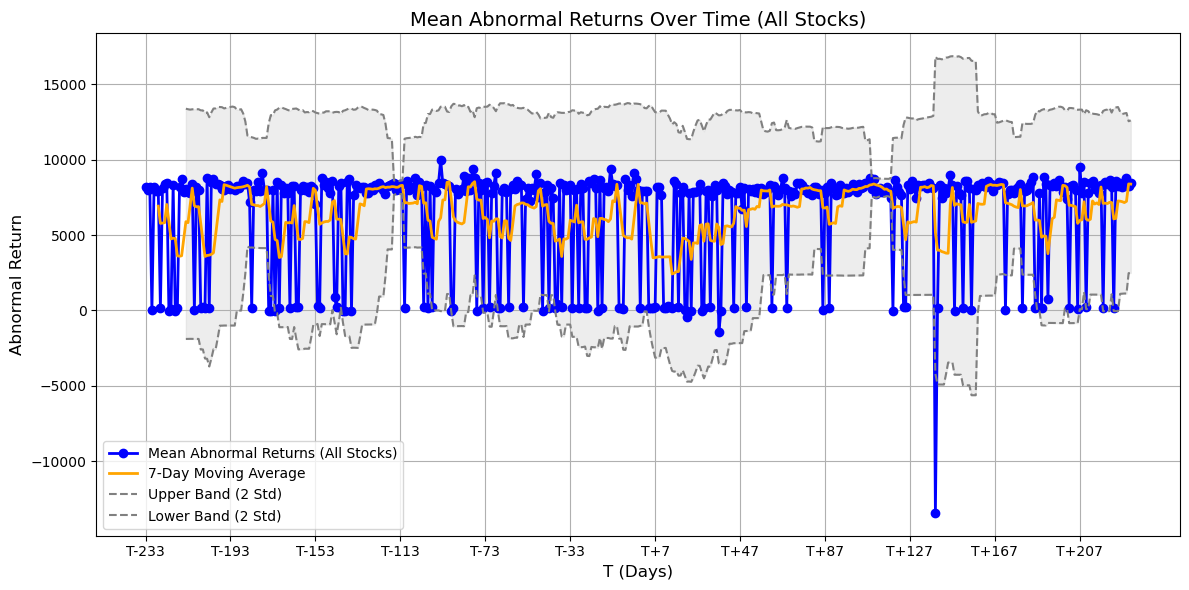

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_abnormal_returns_with_moving_average_all(abnormal_returns_df, window=20, ma_window=7):
    """
    Plot the average abnormal returns across all stocks over time, including a 7-day rolling average.
    Add Bollinger Bands and a grid to the plot for enhanced visualization.
    
    Parameters:
    abnormal_returns_df (pd.DataFrame): The DataFrame containing abnormal returns for all stocks.
    window (int): The moving average window for calculating Bollinger Bands (default: 20).
    ma_window (int): The time window for calculating the rolling average (default: 7 days).
    """
    # Calculate the mean of all stock abnormal returns for each date
    mean_abnormal_returns = abnormal_returns_df.mean(axis=1)

    # Instead of using the actual date as the x-axis, we will use T- values
    t_values = range(-len(mean_abnormal_returns)//2, len(mean_abnormal_returns)//2)  # Ensure length matches abnormal data

    # Calculate Bollinger Bands
    rolling_mean = mean_abnormal_returns.rolling(window=window).mean()
    rolling_std = mean_abnormal_returns.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)  # Two standard deviations above
    lower_band = rolling_mean - (rolling_std * 2)  # Two standard deviations below

    # Calculate 7-day moving average
    moving_average = mean_abnormal_returns.rolling(window=ma_window).mean()

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the average abnormal returns across all stocks
    ax.plot(t_values, mean_abnormal_returns, label='Mean Abnormal Returns (All Stocks)', color='b', lw=2, marker='o')

    # Plot the 7-day moving average
    ax.plot(t_values, moving_average, label=f'{ma_window}-Day Moving Average', color='orange', lw=2)

    # Plot the Bollinger Bands
    ax.plot(t_values, upper_band, label='Upper Band (2 Std)', color='grey', linestyle='--', lw=1.5)
    ax.plot(t_values, lower_band, label='Lower Band (2 Std)', color='grey', linestyle='--', lw=1.5)
    ax.fill_between(t_values, lower_band, upper_band, color='lightgrey', alpha=0.4)

    # Set custom x-axis ticks every 40 points to avoid crowding, label them as T values
    ax.set_xticks(t_values[::40])
    ax.set_xticklabels([f'T{("+" if t > 0 else "")}{t}' for t in t_values[::40]])

    # Add labels and title
    ax.set_xlabel('T (Days)', fontsize=12)
    ax.set_ylabel('Abnormal Return', fontsize=12)
    ax.set_title('Mean Abnormal Returns Over Time (All Stocks)', fontsize=14)

    # Add grid, legend, and improve layout
    ax.grid(True)
    ax.legend()
    plt.tight_layout()

    # Display the plot
    plt.show()

# Example usage:
# Assuming `abnormal_returns` is your DataFrame containing abnormal returns across multiple stocks:
plot_abnormal_returns_with_moving_average_all(abnormal_returns)
